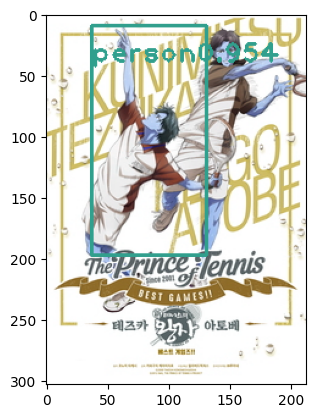

In [9]:
import numpy as np
import cv2 as cv
import sys
import matplotlib.pyplot as plt

def construct_yolo_v3():
    f=open('/home/acy/venv/source/prj_poster/coco_names.txt', 'r')
    class_names=[line.strip() for line in f.readlines()]

    model=cv.dnn.readNet('/home/acy/venv/source/prj_poster/yolov3.weights','/home/acy/venv/source/prj_poster/yolov3.cfg')
    layer_names=model.getLayerNames()
    out_layers=[layer_names[i-1] for i in model.getUnconnectedOutLayers()]
    
    return model,out_layers,class_names

def yolo_detect(img,yolo_model,out_layers):
    height,width=img.shape[0],img.shape[1]
    test_img=cv.dnn.blobFromImage(img,1.0/256,(448,448),(0,0,0),swapRB=True)
    
    yolo_model.setInput(test_img)
    output3=yolo_model.forward(out_layers)
    
    box,conf,id=[],[],[]		# 박스, 신뢰도, 부류 번호
    for output in output3:
        for vec85 in output:
            scores=vec85[5:]
            class_id=np.argmax(scores)
            confidence=scores[class_id]
            if confidence>0.5:	# 신뢰도가 50% 이상인 경우만 취함
                centerx,centery=int(vec85[0]*width),int(vec85[1]*height)
                w,h=int(vec85[2]*width),int(vec85[3]*height)
                x,y=int(centerx-w/2),int(centery-h/2)
                box.append([x,y,x+w,y+h])
                conf.append(float(confidence))
                id.append(class_id)
            
    ind=cv.dnn.NMSBoxes(box,conf,0.5,0.4)
    objects=[box[i]+[conf[i]]+[id[i]] for i in range(len(box)) if i in ind]
    return objects

model,out_layers,class_names=construct_yolo_v3()		# YOLO 모델 생성
colors=np.random.uniform(0,255,size=(len(class_names),3))	# 부류마다 색깔

img=cv.imread('/home/acy/venv/source/prj_poster/신 테니스의 왕자 베스트 게임즈 테즈카 vs 아토베_85899345920.jpg')
if img is None: sys.exit('파일이 없습니다.')

res=yolo_detect(img,model,out_layers)	# YOLO 모델로 물체 검출

for i in range(len(res)):			# 검출된 물체를 영상에 표시
    x1,y1,x2,y2,confidence,id=res[i]
    text=str(class_names[id])+'%.3f'%confidence
    cv.rectangle(img,(x1,y1),(x2,y2),colors[id],2)
    cv.putText(img,text,(x1,y1+30),cv.FONT_HERSHEY_PLAIN,1.5,colors[id],2)

plt.imshow(img)

# cv.waitKey()
# cv.destroyAllWindows()